# Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

**Objective**: build a series of models to predict the price of Bitcoin. 

Data:
* Prices of Bitcoin from September 2014 to Aug 21 2022: [Yahoo Bitcoin prices](https://finance.yahoo.com/quote/BTC-USD/history/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAABVGVJYDVHn8_jt7zyYbruP5szM7Dkufv2mwxwsGu7zBO6FRJ8ymdnRipSzMOo0nNZ6JWLddkuqDF3rMlMJmylau-uArIUkjDyscdcPXfzVYMOo2n53UU-vPpj0mXnNXrxmw_ZWmvPYrqd60pDcivY0xy-Dp5UdSlVwes633QCrR) 
 

>Roadmap:
* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem) 


In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dfce0627-d5ed-6bed-8aff-921763bf550a)


## Github data

*Can alternatively download data from Github class



In [ ]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-08-23 00:30:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2022-08-23 00:30:06 (44.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas


In [2]:
# Import with pandas 
import pandas as pd

btc_file_path = "/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Projects/BitPredict/BTC-USD.csv"
# Parse dates and set date column to index
df = pd.read_csv(btc_file_path, 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2896 entries, 2014-09-17 to 2022-08-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2896 non-null   float64
 1   High       2896 non-null   float64
 2   Low        2896 non-null   float64
 3   Close      2896 non-null   float64
 4   Adj Close  2896 non-null   float64
 5   Volume     2896 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 158.4 KB


In [4]:
# How many samples do we have?
len(df)

2896

In [5]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


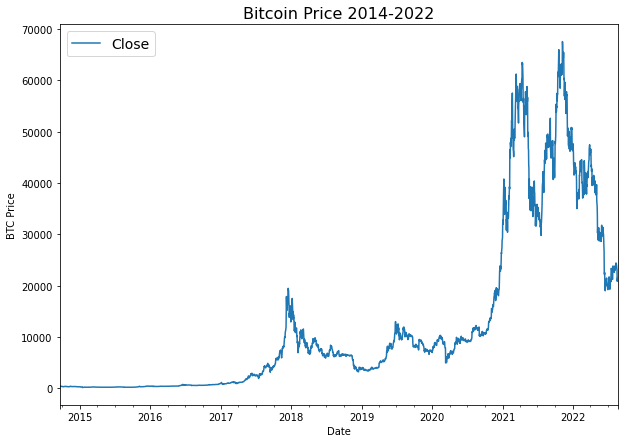

In [6]:
#plot data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Bitcoin Price 2014-2022", fontsize=16)
plt.legend(fontsize=14);

### Importing time series data with Python's CSV module

Using:
* Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html)
* Python's [`datetime`](https://docs.python.org/3/library/datetime.html)

We'll replicate the created plot except this time using Python's `csv` and `datetime` modules.

> 📖 **Resource:** For a great guide on using Python's `csv` module, check out Real Python's tutorial on [Reading and Writing CSV files in Python](https://realpython.com/python-csv/).

In [7]:
#import and format historical Bitcoin data with Python 
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open(btc_file_path, "r") as f:
  csv_reader = csv.reader(f, delimiter=",") #read in the target csv
  next(csv_reader) #skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[4])) #get the closing price as float

#view first 10 of each 
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

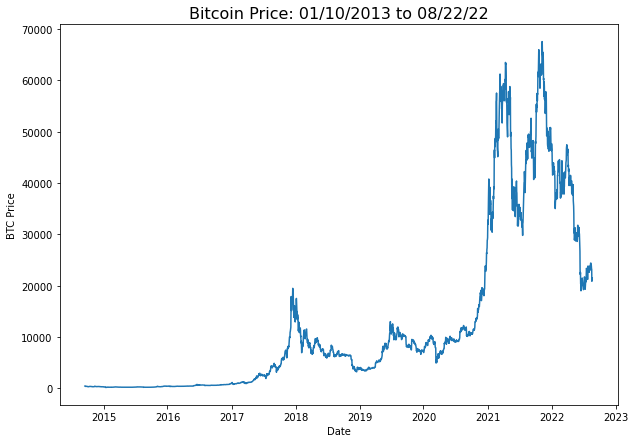

In [8]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Bitcoin Price: 01/10/2013 to 08/22/22", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

### Create train & test sets for time series (the wrong way)

We're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables). 

How about we first see the *wrong way* for splitting time series data?



In [9]:
# turn our DataFrame index and column into NumPy arrays
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [10]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2316,), (580,), (2316,), (580,))

* `train_test_split ` splits data randomly--> e.g. you'd be training and testing on same data and create a data leak compromising the validdity of the model (we have to take the time factor into account)
>We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).

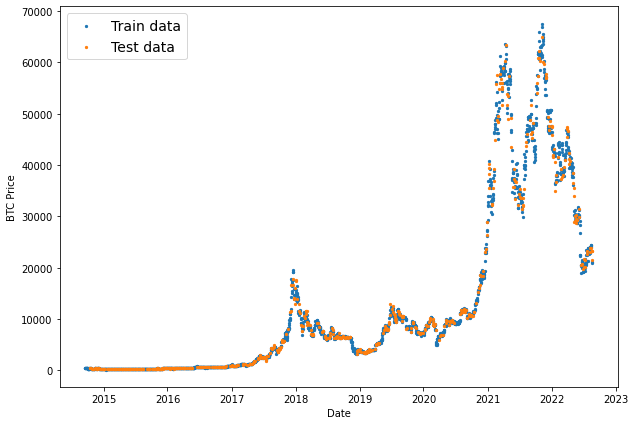

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)



![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2316, 580, 2316, 580)

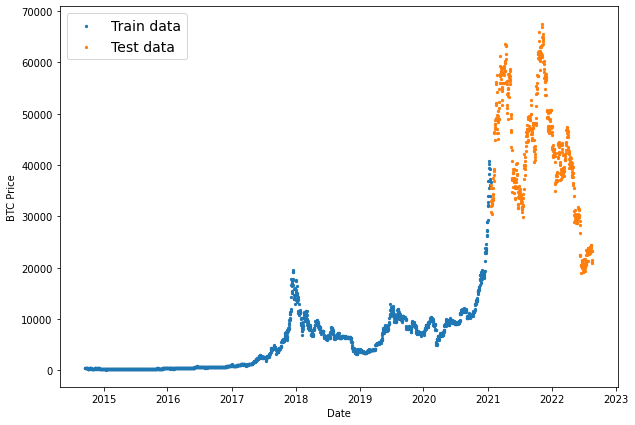

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Use the training set ("past") to train a model to try and predict values on the test set ("future").



> 🔑 **Note:** The amount of data you reserve for your test set not set in stone. You could have 80/20, 90/10, 95/5 splits or in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 **Resource:** Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data.




In [14]:
# Create a function to plot time series data
def plot_time_series(train_timesteps=None, 
                     test_timesteps=None, 
                     train_values=None, 
                     test_values=None, 
                     model_forecast=None, 
                     model_values=None,
                     model_label = None,
                     format_train='.', 
                     format_test=".",
                     format_model=".",
                     start=0, 
                     end=None, 
                     label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.figure(figsize=(10, 7))
  if train_timesteps is None:
    pass
  else:
    plt.plot(train_timesteps[start:end], train_values[start:end], format_train, label="Train data")
  if test_timesteps is None:
    pass
  else:
    plt.plot(test_timesteps[start:end], test_values[start:end], format_test, label="Test data")
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if model_forecast is None:
    pass

  else:
      plt.plot(model_forecast, model_values, format_model, label=model_label)
  plt.legend()
  

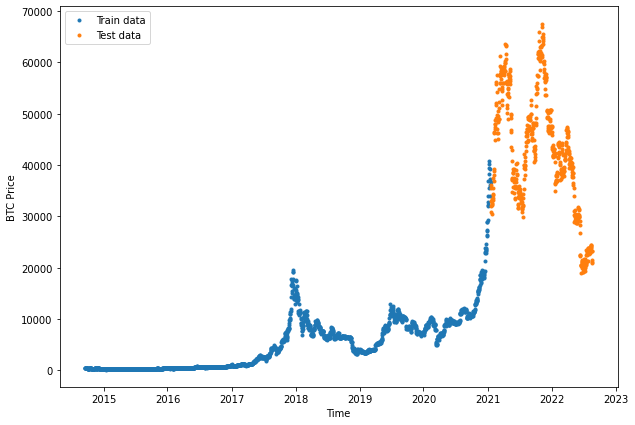

In [15]:
# Try out our plotting function
plot_time_series(train_timesteps=X_train,
                 test_timesteps=X_test,
                 train_values=y_train, 
                 test_values=y_test)

## Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [16]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([36069.804688, 35547.75    , 30825.699219, 33005.761719,
        32067.642578, 32289.378906, 32366.392578, 32569.849609,
        30432.546875, 33466.097656]),
 array([23957.529297, 24402.818359, 24424.068359, 24319.333984,
        24136.972656, 23883.291016, 23335.998047, 23212.738281,
        20877.552734, 21166.060547]))

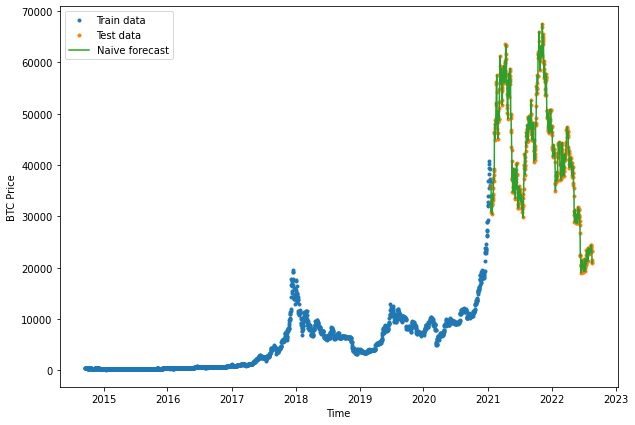

In [17]:
# Plot naive forecast
plot_time_series(train_timesteps=X_train,
                 test_timesteps=X_test,
                 train_values=y_train, 
                 test_values=y_test,
                 model_forecast=X_test[1:], 
                 model_values=naive_forecast,  
                 model_label="Naive forecast",
                 format_model="-")

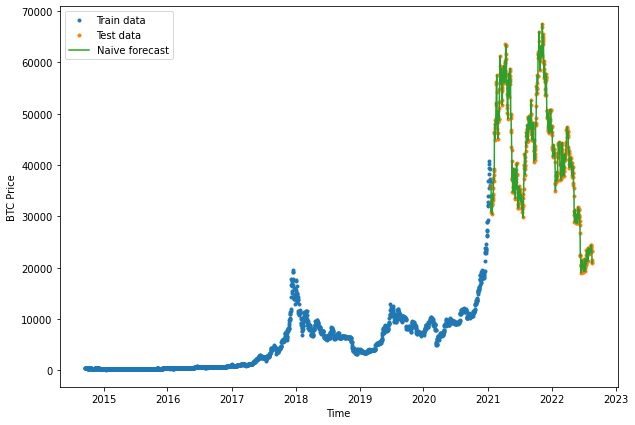

In [18]:
# offset the values by 300 timesteps 
offset = 300 

plot_time_series(train_timesteps=X_train,
                 test_timesteps=X_test,
                 train_values=y_train, 
                 test_values=y_test,
                 model_forecast=X_test[1:], 
                 model_values=naive_forecast,  
                 model_label="Naive forecast",
                 format_model="-")

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin).

Thus, we can use regression evaluation metrics to evaluate our time series forecasts.

What we will be evaluating : 
* **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.




In [19]:
# get TensorFlow
import tensorflow as tf

TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), we need to create our own.

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [20]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [21]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [22]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 1182.6268,
 'mse': 2757842.0,
 'rmse': 1660.6752,
 'mape': 2.8414168,
 'mase': 0.99903446}

In [23]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

42235.57318167069

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $42,236 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $1183




>## Other kinds of time series forecasting models which can be used for baselines and actual forecasts
>There are many other kinds of models you may want to look into for building baselines/performing forecasts. They will need to be considered when working with different types of time series problems.


>| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

Why do we window?

* Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```


Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [24]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [25]:
# Create function to label windowed data
def get_labelled_windows(x, horizon):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [26]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8




Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [27]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size, horizon):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [28]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2889, 2889)

In [29]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [30]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [24402.818359 24424.068359 24319.333984 24136.972656 23883.291016
 23335.998047 23212.738281] -> Label: [20877.552734]
Window: [24424.068359 24319.333984 24136.972656 23883.291016 23335.998047
 23212.738281 20877.552734] -> Label: [21166.060547]
Window: [24319.333984 24136.972656 23883.291016 23335.998047 23212.738281
 20877.552734 21166.060547] -> Label: [21534.121094]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).


## Turning windows into training and test sets 

With windowing usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [31]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2311, 578, 2311, 578)

In [33]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]), array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [34]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing each model's best performance to other models optimal performance.

>For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

We can use [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

* The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

> 🔑 **Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

* To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [35]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs



> 🔑 **Note:** the values chosen above have been obtained experimentally via hyperparameter tuning


In [36]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
19/19 [==============================] - 3s 36ms/step - loss: 1319.2848 - mae: 1319.2848 - val_loss: 5267.8696 - val_mae: 5267.8696
Epoch 2/100
19/19 [==============================] - 0s 24ms/step - loss: 351.4384 - mae: 351.4384 - val_loss: 2571.6501 - val_mae: 2571.6501
Epoch 3/100
19/19 [==============================] - 0s 24ms/step - loss: 271.4176 - mae: 271.4176 - val_loss: 2287.8992 - val_mae: 2287.8992
Epoch 4/100
19/19 [==============================] - 0s 23ms/step - loss: 262.8633 - mae: 262.8633 - val_loss: 1945.7211 - val_mae: 1945.7211
Epoch 5/100
19/19 [==============================] - 0s 23ms/step - loss: 247.9343 - mae: 247.9343 - val_loss: 1863.1436 - val_mae: 1863.1436
Epoch 6/100
19/19 [==============================] - 1s 33ms/step - loss: 242.4469 - mae: 242.4469 - val_loss: 1827.6104 - val_mae: 1827.6104
Epoch 7/100
19/19 [==============================] - 0s 23ms/step - loss: 237.1522 - mae: 237.1522 - val_loss: 1816.8112 - val_mae: 1816.8112
Epoc

In [37]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

19/19 [==============================] - 0s 2ms/step - loss: 1390.5228 - mae: 1390.5228


[1390.5228271484375, 1390.5228271484375]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [38]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

19/19 [==============================] - 0s 2ms/step - loss: 1201.9188 - mae: 1201.9188


[1201.9188232421875, 1201.9188232421875]

## Making forecasts with a model (on the test datasets)

>Note: these wont' be actual forecasts, they're only pseudo forecasts becuase actual forecasts are into the future

Write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [39]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data

  """
  forecast = model.predict(input_data)
  forecast_1d = tf.squeeze(forecast) # return 1D array of predictions
  return forecast_1d

In [40]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(578, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([35689.18 , 31576.205, 32589.729, 32084.254, 32365.729, 31980.463,
        32839.1  , 30739.133, 32979.453, 34208.66 ], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [41]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1201.919,
 'mse': 2821956.8,
 'rmse': 1679.868,
 'mape': 2.9031937,
 'mase': 1.0206188}

In [42]:
naive_results

{'mae': 1182.6268,
 'mse': 2757842.0,
 'rmse': 1660.6752,
 'mape': 2.8414168,
 'mase': 0.99903446}

It looks like our naïve model beats our first deep model on nearly every metric.


Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

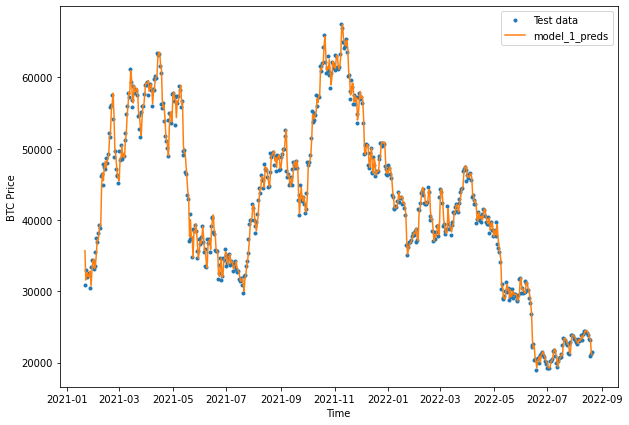

In [43]:
offset = 300
plot_time_series(train_timesteps=None,
                 test_timesteps=X_test[-len(test_windows):],
                 train_values=None, 
                 test_values=test_labels[:, 0],
                 model_forecast=X_test[-len(test_windows):], 
                 model_values=model_1_preds,  
                 model_label="model_1_preds",
                 format_model="-",
                 )

Model 2: Dense (window=30, horizon=1)

Create a replica of model_1 but set;
* `window` = 30
* `horizon` = 1

In [44]:
#set new params
HORIZON_2 = 1 # predict one step at a time
WINDOW_SIZE_2 = 30 # use 30 timesteps in the past

Preprocess data again to work with model_2 since we are changeing the parameters above 

In [45]:
#turn data into windows using the make_windows function
full_windows_2, full_labels_2 = make_windows(prices, window_size=WINDOW_SIZE_2, horizon=HORIZON_2)
len(full_windows), len(full_labels)

(2889, 2889)

In [46]:
#split data using make_train_test_splits
train_windows_2, test_windows_2, train_labels_2, test_labels_2 = make_train_test_splits(full_windows_2, full_labels_2)
len(train_windows_2), len(test_windows_2), len(train_labels_2), len(test_labels_2)

(2292, 574, 2292, 574)

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_2, activation="linear") # linear activation is the same as having no activation                        
], name="model_2_dense") # give the model a name so we can save it

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_2.fit(x=train_windows_2, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels_2, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_2, test_labels_2),
            callbacks=[create_model_checkpoint(model_name=model_2.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 1s 29ms/step - loss: 1636.3223 - mae: 1636.3223 - val_loss: 4580.0400 - val_mae: 4580.0400
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 726.8832 - mae: 726.8832 - val_loss: 5427.4292 - val_mae: 5427.4292
Epoch 3/100
18/18 [==============================] - 1s 31ms/step - loss: 483.0392 - mae: 483.0392 - val_loss: 3611.4712 - val_mae: 3611.4712
Epoch 4/100
18/18 [==============================] - 1s 49ms/step - loss: 390.1423 - mae: 390.1423 - val_loss: 2795.0469 - val_mae: 2795.0469
Epoch 5/100
18/18 [==============================] - 1s 39ms/step - loss: 349.3418 - mae: 349.3418 - val_loss: 2360.2681 - val_mae: 2360.2681
Epoch 6/100
18/18 [==============================] - 1s 61ms/step - loss: 288.7023 - mae: 288.7023 - val_loss: 2127.1140 - val_mae: 2127.1140
Epoch 7/100
18/18 [==============================] - 1s 60ms/step - loss: 283.7870 - mae: 283.7870 - val_loss: 2090.6716 - val_mae: 2090.6716
Epoch

In [48]:
# Evaluate model 2 preds
model_2.evaluate(test_windows_2, test_labels_2)

18/18 [==============================] - 0s 2ms/step - loss: 1291.1589 - mae: 1291.1589


[1291.158935546875, 1291.158935546875]

In [49]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows_2, test_labels_2)

18/18 [==============================] - 0s 2ms/step - loss: 1287.4954 - mae: 1287.4954


[1287.495361328125, 1287.495361328125]

In [50]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows_2)

In [51]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels_2), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1287.4954,
 'mse': 3075856.2,
 'rmse': 1753.8119,
 'mape': 3.105265,
 'mase': 1.0911949}

* It looks like `model_2` performs worse than the naïve model as well as `model_1`


In [52]:
model_1_results

{'mae': 1201.919,
 'mse': 2821956.8,
 'rmse': 1679.868,
 'mape': 2.9031937,
 'mase': 1.0206188}

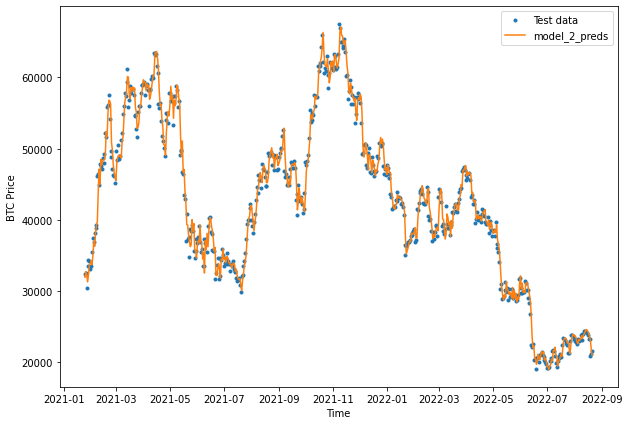

In [53]:
#visualize model_2
offset = 300
plot_time_series(train_timesteps=None,
                 test_timesteps=X_test[-len(test_windows_2):],
                 train_values=None, 
                 test_values=test_labels_2[:, 0],
                 model_forecast=X_test[-len(test_windows_2):], 
                 model_values=model_2_preds,  
                 model_label="model_2_preds",
                 format_model="-",
                 )

##Model 3

Create a replica of model_1 but set;
* `window` = 30
* `horizon` = 7

In [54]:
#set new params
HORIZON_3 = 7 
WINDOW_SIZE_3 = 30 

Preprocess data again to work with model_3 since we are changeing the parameters above 

In [55]:
#turn data into windows using the make_windows function
full_windows_3, full_labels_3 = make_windows(prices, window_size=WINDOW_SIZE_3, horizon=HORIZON_3)
len(full_windows), len(full_labels)

(2889, 2889)

In [56]:
#split data using make_train_test_splits
train_windows_3, test_windows_3, train_labels_3, test_labels_3 = make_train_test_splits(full_windows_3, full_labels_3)
len(train_windows_3), len(test_windows_3), len(train_labels_3), len(test_labels_3)

(2288, 572, 2288, 572)

In [57]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_3, activation="linear") # linear activation is the same as having no activation                        
], name="model_3_dense") # give the model a name so we can save it

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_3.fit(x=train_windows_3, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels_3, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_3, test_labels_3),
            callbacks=[create_model_checkpoint(model_name=model_3.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 1s 32ms/step - loss: 2331.5872 - mae: 2331.5872 - val_loss: 8924.9170 - val_mae: 8924.9170
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 899.6098 - mae: 899.6098 - val_loss: 5592.6909 - val_mae: 5592.6909
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 714.3920 - mae: 714.3920 - val_loss: 4440.9624 - val_mae: 4440.9624
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 634.1637 - mae: 634.1637 - val_loss: 4149.3896 - val_mae: 4149.3896
Epoch 5/100
18/18 [==============================] - 0s 24ms/step - loss: 570.2396 - mae: 570.2396 - val_loss: 3765.3081 - val_mae: 3765.3081
Epoch 6/100
18/18 [==============================] - 0s 24ms/step - loss: 521.6497 - mae: 521.6497 - val_loss: 3498.3579 - val_mae: 3498.3579
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 499.7239 - mae: 499.7239 - val_loss: 3587.0537 - val_mae: 3587.0537
Epoch

In [58]:
# Evaluate model_3 preds
model_3.evaluate(test_windows_3, test_labels_3)

18/18 [==============================] - 0s 2ms/step - loss: 2580.1648 - mae: 2580.1648


[2580.164794921875, 2580.164794921875]

In [59]:
# Load in best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows_3, test_labels_3)

18/18 [==============================] - 0s 2ms/step - loss: 2551.6919 - mae: 2551.6919


[2551.69189453125, 2551.69189453125]

In [60]:
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows_3)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[35118.906, 34343.527, 34896.367, 33826.836, 34381.277, 35059.65 ,
        33126.1  ],
       [32888.098, 32486.809, 32972.15 , 31244.244, 32594.523, 31993.959,
        32633.643],
       [33271.766, 32952.81 , 32685.242, 31789.883, 32754.197, 31609.541,
        32652.74 ],
       [32370.535, 31616.08 , 31210.797, 31967.63 , 31843.207, 31256.986,
        30990.977],
       [31865.496, 31703.006, 30107.672, 31546.826, 31037.55 , 31170.69 ,
        29794.805]], dtype=float32)>

In [61]:
# Evaluate results for model 2 predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels_3), # remove 1 dimension of test labels
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 2456.4846 ,   680.0413 ,  1258.3175 ,  1669.492  ,  1901.3016 ,
         2140.1858 ,  2674.327  ,  4191.1006 ,  3156.8909 ,  2788.767  ,
         3230.926  ,  3634.851  ,  5895.6875 ,  6098.45   ,  5612.1353 ,
         6370.335  ,  6597.222  ,  6991.7065 ,  8443.675  ,  4500.538  ,
         1558.3572 ,  1777.4308 ,  1264.0927 ,  2146.5325 ,  2425.1428 ,
         3153.3833 ,  3608.6016 ,  4282.5244 ,  3055.7036 ,  3993.1394 ,
         4726.4644 ,  6611.026  ,  9204.721  ,  8364.732  ,  4618.762  ,
         2559.     ,  2122.9832 ,  2268.1458 ,  3855.1719 ,  5615.6333 ,
         3515.6094 ,  3814.3762 ,  3928.237  ,  4495.747  ,  6105.6484 ,
         6936.657  ,  5749.471  ,  5565.9517 ,  4256.4995 ,  3209.2834 ,
         1802.6881 ,  1468.1077 ,  1478.6512 ,  2954.7227 ,  1621.5156 ,
         2435.763  ,  3238.4844 ,  4457.399  ,  5399.441  ,  4910.04   ,
         4056.4067 ,  1538.6506 ,  2451.2466 ,  4178.3706 ,  5826.9077 ,
         5486.442  ,  3953.0083 ,  3317.1301

* `model_3` results are multi-dimensional because
we're trying to predict more than one step at a time.


## Make our evaluation function work for larger horizons

`model_3_results` are multi-dimensional due to predictions being evaluated across the `HORIZON` timesteps (7 predictions at a time).

* To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [62]:
#create a new evaluate_preds to work with multiple data shapes
def evaluate_preds_gen(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [63]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds_gen(y_true=tf.squeeze(test_labels_3),
                                     y_pred=model_3_preds)
model_3_results

{'mae': 2551.692,
 'mse': 12212732.0,
 'rmse': 2916.6533,
 'mape': 6.137846,
 'mase': 2.1606758}

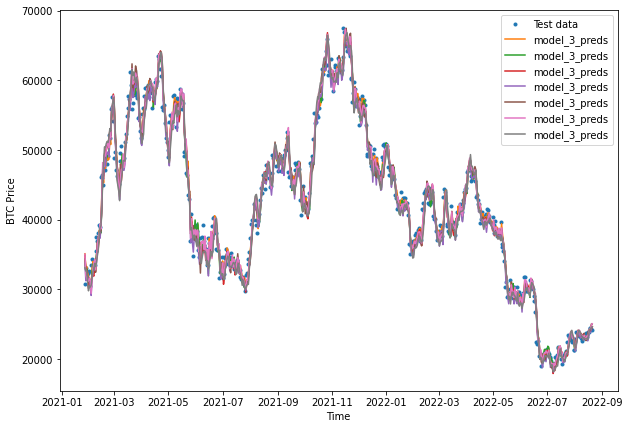

In [64]:
#visualize model_3
plot_time_series(train_timesteps=None,
                 test_timesteps=X_test[-len(test_windows_3):],
                 train_values=None, 
                 test_values=test_labels_3[:, 0],
                 model_forecast=X_test[-len(test_windows_3):], 
                 model_values=model_3_preds,  
                 model_label="model_3_preds",
                 format_model="-",
                 )

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 **Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

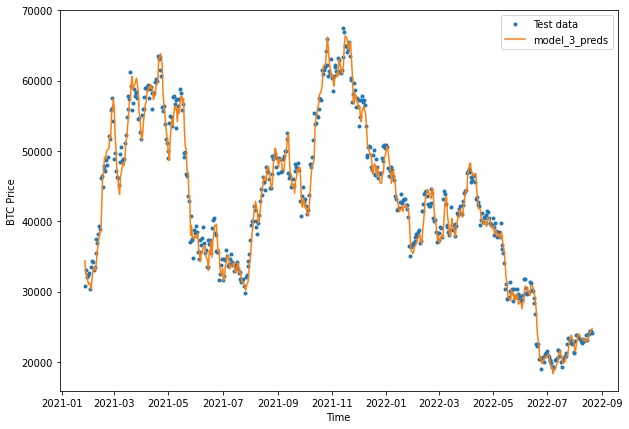

In [65]:
#visualize model_3 with aggregated results 
plot_time_series(train_timesteps=None,
                 test_timesteps=X_test[-len(test_windows_3):],
                 train_values=None, 
                 test_values=test_labels_3[:, 0],
                 model_forecast=X_test[-len(test_windows_3):], 
                 model_values=tf.reduce_mean(model_3_preds, axis=1),  
                 model_label="model_3_preds",
                 format_model="-",
                 )

## Performance Check

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

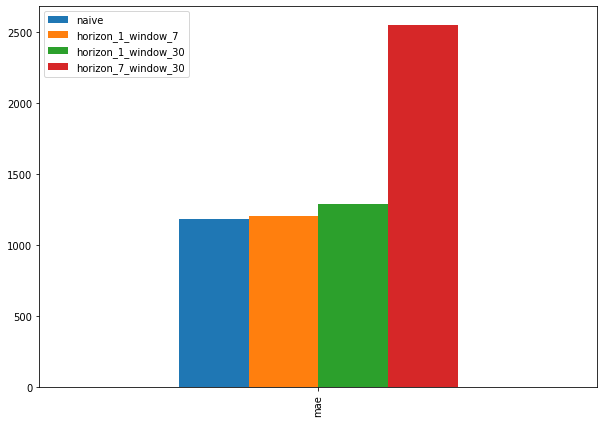

In [66]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

* The `naïve` model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D

Conv1D models can be used for seq2seq (sequence to sequence) problems.
* In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (e.g., many to one problem).

![bitcoin prediction in seq2seq terms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)
*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem. The diagram comes from Andrei Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*.



In [67]:
HORIZON_4 = 1 # predict next day
WINDOW_SIZE_4 = 7 # use previous week worth of data

In [68]:
# Create windowed dataset
full_windows_4, full_labels_4 = make_windows(prices, window_size=WINDOW_SIZE_4, horizon=HORIZON_4)
len(full_windows_4), len(full_labels_4)

(2889, 2889)

In [69]:
# Create train/test splits
train_windows_4, test_windows_4, train_labels_4, test_labels_4 = make_train_test_splits(full_windows_4, full_labels_4)
len(train_windows_4), len(test_windows_4), len(train_labels_4), len(test_labels_4)

(2311, 578, 2311, 578)

Since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

>In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [70]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) 
* The Lambda layer wraps a function into a layer which can be used with a model.



In [71]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])

# add an extra dimension for timesteps
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) 

#printout
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]




Now we've got a Lambda layer, let's build, compile, fit and evaluate a Conv1D model on our data.

> 🔑 **Note:** If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [72]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON_4)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows_4,
            train_labels_4,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows_4, test_labels_4),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
19/19 [==============================] - 9s 63ms/step - loss: 2038.8246 - val_loss: 6216.9385
Epoch 2/100
19/19 [==============================] - 1s 33ms/step - loss: 478.4613 - val_loss: 2153.4192
Epoch 3/100
19/19 [==============================] - 1s 34ms/step - loss: 298.1326 - val_loss: 2024.1250
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 270.3427 - val_loss: 2191.9512
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 272.7820 - val_loss: 2031.4263
Epoch 6/100
19/19 [==============================] - 1s 34ms/step - loss: 263.5850 - val_loss: 1926.8713
Epoch 7/100
19/19 [==============================] - 1s 34ms/step - loss: 260.2386 - val_loss: 1897.1185
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 249.4192 - val_loss: 1990.7867
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 253.9140 - val_loss: 1923.7943
Epoch 10/100
19/19 [==============================] - 1s 3

In [73]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows_4, test_labels_4)

19/19 [==============================] - 0s 3ms/step - loss: 1207.5094


1207.5093994140625

In [75]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows_4)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([35486.27 , 31608.479, 32429.87 , 32125.877, 32072.012, 32046.828,
       32496.629, 30727.475, 32752.434, 34113.973], dtype=float32)>

In [76]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels_4),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 1207.5094,
 'mse': 2808135.0,
 'rmse': 1675.749,
 'mape': 2.9046328,
 'mase': 1.025366}

## Model 5: RNN (LSTM)
We'll reuse the data from the Conv1D model and create an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data. 

Note: in oder to use a LSTM model we will be need to convert our data into the right shape.
* [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.
* `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).
* To fix this, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer like in the previous model.

> 📖 **Resource:** For more on the different types of recurrent neural networks you can use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

















In [77]:
#set params (same as Conv1D model)
HORIZON_5 = 1 
WINDOW_SIZE_5 = 7 

In [78]:
tf.random.set_seed(42)

# build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE_5))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON_5)(x)

#create model instance 
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows_4,
            train_labels_4,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_4, test_labels_4),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
12/19 [=================>............] - ETA: 0s - loss: 4296.3828 

19/19 [==============================] - 3s 105ms/step - loss: 3911.3872 - val_loss: 20617.7051
Epoch 2/100
11/19 [================>.............] - ETA: 0s - loss: 1864.9764

19/19 [==============================] - 2s 97ms/step - loss: 1379.0854 - val_loss: 2513.3398
Epoch 3/100
12/19 [=================>............] - ETA: 0s - loss: 446.7595

19/19 [==============================] - 2s 109ms/step - loss: 396.0788 - val_loss: 2223.4072
Epoch 4/100
12/19 [=================>............] - ETA: 0s - loss: 280.2663

19/19 [==============================] - 2s 95ms/step - loss: 278.7733 - val_loss: 2143.6462
Epoch 5/100
11/19 [================>.............] - ETA: 0s - loss: 265.7700

19/19 [==============================] - 2s 93ms/step - loss: 263.8765 - val_loss: 2084.9856
Epoch 6/100
12/19 [=================>............] - ETA: 0s - loss: 257.6385

19/19 [==============================] - 2s 93ms/step - loss: 261.3934 - val_loss: 1974.8021
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 255.9126 - val_loss: 2028.1505
Epoch 8/100
12/19 [=================>............] - ETA: 0s - loss: 263.3226

19/19 [==============================] - 2s 114ms/step - loss: 254.6810 - val_loss: 1930.3470
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 258.0824 - val_loss: 1943.8138
Epoch 10/100
19/19 [==============================] - 0s 6ms/step - loss: 250.8974 - val_loss: 2036.3478
Epoch 11/100
19/19 [==============================] - 0s 7ms/step - loss: 257.2670 - val_loss: 1941.7911
Epoch 12/100
10/19 [==============>...............] - ETA: 0s - loss: 232.4215

19/19 [==============================] - 2s 95ms/step - loss: 246.3465 - val_loss: 1861.9010
Epoch 13/100
12/19 [=================>............] - ETA: 0s - loss: 237.3688

19/19 [==============================] - 2s 96ms/step - loss: 244.1546 - val_loss: 1836.9313
Epoch 14/100
11/19 [================>.............] - ETA: 0s - loss: 256.4158

19/19 [==============================] - 2s 111ms/step - loss: 244.7289 - val_loss: 1826.8610
Epoch 15/100
11/19 [================>.............] - ETA: 0s - loss: 239.5238

19/19 [==============================] - 2s 96ms/step - loss: 242.2587 - val_loss: 1805.4841
Epoch 16/100
19/19 [==============================] - 0s 6ms/step - loss: 242.5048 - val_loss: 1808.5844
Epoch 17/100
12/19 [=================>............] - ETA: 0s - loss: 219.4878

19/19 [==============================] - 2s 95ms/step - loss: 234.1443 - val_loss: 1783.5677
Epoch 18/100
11/19 [================>.............] - ETA: 0s - loss: 229.6891

19/19 [==============================] - 2s 94ms/step - loss: 230.2217 - val_loss: 1751.5859
Epoch 19/100
19/19 [==============================] - 0s 6ms/step - loss: 227.5584 - val_loss: 1754.4373
Epoch 20/100
11/19 [================>.............] - ETA: 0s - loss: 217.3996

19/19 [==============================] - 2s 111ms/step - loss: 224.2235 - val_loss: 1707.1470
Epoch 21/100
11/19 [================>.............] - ETA: 0s - loss: 223.7985

19/19 [==============================] - 2s 94ms/step - loss: 223.3531 - val_loss: 1684.0538
Epoch 22/100
11/19 [================>.............] - ETA: 0s - loss: 220.5845

19/19 [==============================] - 2s 93ms/step - loss: 219.0553 - val_loss: 1664.1660
Epoch 23/100
19/19 [==============================] - 0s 7ms/step - loss: 215.9530 - val_loss: 1683.0111
Epoch 24/100
12/19 [=================>............] - ETA: 0s - loss: 212.2925

19/19 [==============================] - 2s 93ms/step - loss: 213.1692 - val_loss: 1630.9265
Epoch 25/100
12/19 [=================>............] - ETA: 0s - loss: 209.9106

19/19 [==============================] - 2s 112ms/step - loss: 214.9765 - val_loss: 1610.0317
Epoch 26/100
12/19 [=================>............] - ETA: 0s - loss: 210.1522

19/19 [==============================] - 2s 95ms/step - loss: 211.2599 - val_loss: 1596.6179
Epoch 27/100
19/19 [==============================] - 0s 6ms/step - loss: 208.8654 - val_loss: 1673.4124
Epoch 28/100
12/19 [=================>............] - ETA: 0s - loss: 201.4089

19/19 [==============================] - 2s 92ms/step - loss: 208.7223 - val_loss: 1565.5652
Epoch 29/100
11/19 [================>.............] - ETA: 0s - loss: 202.6389

19/19 [==============================] - 2s 110ms/step - loss: 202.8713 - val_loss: 1548.5414
Epoch 30/100
19/19 [==============================] - 0s 7ms/step - loss: 202.6710 - val_loss: 1579.5342
Epoch 31/100
12/19 [=================>............] - ETA: 0s - loss: 186.9641

19/19 [==============================] - 2s 95ms/step - loss: 197.6455 - val_loss: 1547.4341
Epoch 32/100
12/19 [=================>............] - ETA: 0s - loss: 201.4194

19/19 [==============================] - 2s 97ms/step - loss: 196.5121 - val_loss: 1507.8204
Epoch 33/100
19/19 [==============================] - 0s 7ms/step - loss: 194.0707 - val_loss: 1577.4756
Epoch 34/100
11/19 [================>.............] - ETA: 0s - loss: 193.6285

19/19 [==============================] - 2s 96ms/step - loss: 193.3984 - val_loss: 1475.0101
Epoch 35/100
12/19 [=================>............] - ETA: 0s - loss: 186.8325

19/19 [==============================] - 2s 112ms/step - loss: 189.1708 - val_loss: 1463.2102
Epoch 36/100
19/19 [==============================] - 0s 6ms/step - loss: 188.0036 - val_loss: 1473.0437
Epoch 37/100
12/19 [=================>............] - ETA: 0s - loss: 190.9252

19/19 [==============================] - 2s 96ms/step - loss: 193.7953 - val_loss: 1437.2704
Epoch 38/100
11/19 [================>.............] - ETA: 0s - loss: 185.6729

19/19 [==============================] - 2s 94ms/step - loss: 184.0315 - val_loss: 1428.9171
Epoch 39/100
11/19 [================>.............] - ETA: 0s - loss: 181.4076

19/19 [==============================] - 2s 109ms/step - loss: 183.0987 - val_loss: 1419.8182
Epoch 40/100
11/19 [================>.............] - ETA: 0s - loss: 177.3167

19/19 [==============================] - 2s 94ms/step - loss: 183.1779 - val_loss: 1412.8087
Epoch 41/100
19/19 [==============================] - 0s 6ms/step - loss: 185.5014 - val_loss: 1452.6136
Epoch 42/100
19/19 [==============================] - 0s 6ms/step - loss: 186.5355 - val_loss: 1488.6915
Epoch 43/100
17/19 [=========================>....] - ETA: 0s - loss: 188.5843

19/19 [==============================] - 2s 94ms/step - loss: 186.4495 - val_loss: 1401.4121
Epoch 44/100
12/19 [=================>............] - ETA: 0s - loss: 172.9043

19/19 [==============================] - 2s 93ms/step - loss: 176.8620 - val_loss: 1384.1951
Epoch 45/100
11/19 [================>.............] - ETA: 0s - loss: 185.6067

19/19 [==============================] - 2s 113ms/step - loss: 177.4413 - val_loss: 1378.0902
Epoch 46/100
19/19 [==============================] - 0s 7ms/step - loss: 178.7614 - val_loss: 1404.4576
Epoch 47/100
19/19 [==============================] - 0s 6ms/step - loss: 177.1134 - val_loss: 1424.9144
Epoch 48/100
19/19 [==============================] - 0s 6ms/step - loss: 176.1829 - val_loss: 1423.5072
Epoch 49/100
19/19 [==============================] - 0s 7ms/step - loss: 179.1851 - val_loss: 1418.1912
Epoch 50/100
11/19 [================>.............] - ETA: 0s - loss: 189.1973

19/19 [==============================] - 2s 95ms/step - loss: 184.3384 - val_loss: 1350.1168
Epoch 51/100
19/19 [==============================] - 0s 7ms/step - loss: 177.3116 - val_loss: 1357.8287
Epoch 52/100
19/19 [==============================] - 0s 7ms/step - loss: 173.5769 - val_loss: 1378.9631
Epoch 53/100
12/19 [=================>............] - ETA: 0s - loss: 186.5937

19/19 [==============================] - 2s 94ms/step - loss: 178.3895 - val_loss: 1344.4552
Epoch 54/100
19/19 [==============================] - 0s 6ms/step - loss: 172.2213 - val_loss: 1506.7817
Epoch 55/100
19/19 [==============================] - 0s 7ms/step - loss: 185.0845 - val_loss: 1405.7985
Epoch 56/100
19/19 [==============================] - 0s 7ms/step - loss: 172.0711 - val_loss: 1480.4734
Epoch 57/100
19/19 [==============================] - 0s 7ms/step - loss: 182.5635 - val_loss: 1392.8281
Epoch 58/100
11/19 [================>.............] - ETA: 0s - loss: 171.5020

19/19 [==============================] - 2s 94ms/step - loss: 174.3530 - val_loss: 1332.4750
Epoch 59/100
11/19 [================>.............] - ETA: 0s - loss: 172.3792

19/19 [==============================] - 2s 114ms/step - loss: 168.6753 - val_loss: 1332.3480
Epoch 60/100
11/19 [================>.............] - ETA: 0s - loss: 167.3666

19/19 [==============================] - 2s 95ms/step - loss: 168.6282 - val_loss: 1323.3154
Epoch 61/100
19/19 [==============================] - 0s 7ms/step - loss: 171.0916 - val_loss: 1352.9681
Epoch 62/100
12/19 [=================>............] - ETA: 0s - loss: 172.8300

19/19 [==============================] - 2s 96ms/step - loss: 167.9611 - val_loss: 1318.5791
Epoch 63/100
19/19 [==============================] - 0s 6ms/step - loss: 168.0664 - val_loss: 1330.5457
Epoch 64/100
11/19 [================>.............] - ETA: 0s - loss: 169.5357

19/19 [==============================] - 2s 95ms/step - loss: 167.6060 - val_loss: 1314.9736
Epoch 65/100
19/19 [==============================] - 0s 7ms/step - loss: 169.1351 - val_loss: 1342.0680
Epoch 66/100
19/19 [==============================] - 0s 6ms/step - loss: 176.4325 - val_loss: 1466.0417
Epoch 67/100
12/19 [=================>............] - ETA: 0s - loss: 170.8181

19/19 [==============================] - 2s 113ms/step - loss: 171.7665 - val_loss: 1313.2819
Epoch 68/100
19/19 [==============================] - 0s 7ms/step - loss: 170.1486 - val_loss: 1314.5863
Epoch 69/100
12/19 [=================>............] - ETA: 0s - loss: 166.0390

19/19 [==============================] - 2s 96ms/step - loss: 167.2491 - val_loss: 1311.1621
Epoch 70/100
12/19 [=================>............] - ETA: 0s - loss: 168.4724

19/19 [==============================] - 2s 94ms/step - loss: 168.1608 - val_loss: 1309.2074
Epoch 71/100
19/19 [==============================] - 0s 8ms/step - loss: 168.0286 - val_loss: 1342.9768
Epoch 72/100
19/19 [==============================] - 0s 8ms/step - loss: 173.2976 - val_loss: 1344.3999
Epoch 73/100
19/19 [==============================] - 0s 6ms/step - loss: 170.3791 - val_loss: 1606.4220
Epoch 74/100
19/19 [==============================] - 0s 7ms/step - loss: 177.5500 - val_loss: 1364.3713
Epoch 75/100
19/19 [==============================] - 0s 6ms/step - loss: 168.4195 - val_loss: 1324.5232
Epoch 76/100
19/19 [==============================] - 0s 6ms/step - loss: 177.6548 - val_loss: 1423.4954
Epoch 77/100
12/19 [=================>............] - ETA: 0s - loss: 176.5946

19/19 [==============================] - 2s 111ms/step - loss: 168.4743 - val_loss: 1302.2618
Epoch 78/100
12/19 [=================>............] - ETA: 0s - loss: 170.2189

19/19 [==============================] - 2s 94ms/step - loss: 165.2485 - val_loss: 1300.3832
Epoch 79/100
19/19 [==============================] - 0s 6ms/step - loss: 164.4258 - val_loss: 1300.4597
Epoch 80/100
11/19 [================>.............] - ETA: 0s - loss: 156.3144

19/19 [==============================] - 2s 96ms/step - loss: 164.4973 - val_loss: 1295.8136
Epoch 81/100
19/19 [==============================] - 0s 7ms/step - loss: 167.9568 - val_loss: 1302.3351
Epoch 82/100
19/19 [==============================] - 0s 7ms/step - loss: 164.8474 - val_loss: 1372.4061
Epoch 83/100
19/19 [==============================] - 0s 6ms/step - loss: 166.5816 - val_loss: 1382.6776
Epoch 84/100
19/19 [==============================] - 0s 7ms/step - loss: 170.1466 - val_loss: 1324.5293
Epoch 85/100
11/19 [================>.............] - ETA: 0s - loss: 185.9649

19/19 [==============================] - 2s 92ms/step - loss: 172.6129 - val_loss: 1282.9032
Epoch 86/100
19/19 [==============================] - 0s 7ms/step - loss: 168.1112 - val_loss: 1310.7487
Epoch 87/100
19/19 [==============================] - 0s 6ms/step - loss: 168.9048 - val_loss: 1315.7124
Epoch 88/100
11/19 [================>.............] - ETA: 0s - loss: 164.3371

19/19 [==============================] - 2s 114ms/step - loss: 165.9234 - val_loss: 1276.5051
Epoch 89/100
19/19 [==============================] - 0s 7ms/step - loss: 162.7774 - val_loss: 1285.4136
Epoch 90/100
19/19 [==============================] - 0s 7ms/step - loss: 162.9543 - val_loss: 1279.7853
Epoch 91/100
19/19 [==============================] - ETA: 0s - loss: 162.8167

19/19 [==============================] - 2s 98ms/step - loss: 162.8167 - val_loss: 1272.8220
Epoch 92/100
19/19 [==============================] - 0s 6ms/step - loss: 161.3150 - val_loss: 1313.9070
Epoch 93/100
19/19 [==============================] - 0s 7ms/step - loss: 166.5517 - val_loss: 1356.2523
Epoch 94/100
11/19 [================>.............] - ETA: 0s - loss: 169.6689

19/19 [==============================] - 2s 96ms/step - loss: 165.0779 - val_loss: 1270.3518
Epoch 95/100
19/19 [==============================] - 0s 7ms/step - loss: 168.6013 - val_loss: 1344.0685
Epoch 96/100
19/19 [==============================] - 0s 7ms/step - loss: 165.4584 - val_loss: 1660.0458
Epoch 97/100
19/19 [==============================] - 0s 8ms/step - loss: 181.8971 - val_loss: 1333.8821
Epoch 98/100
19/19 [==============================] - 0s 8ms/step - loss: 167.7175 - val_loss: 1297.1133
Epoch 99/100
19/19 [==============================] - 0s 9ms/step - loss: 163.9496 - val_loss: 1288.9094
Epoch 100/100
11/19 [================>.............] - ETA: 0s - loss: 162.0972

19/19 [==============================] - 2s 111ms/step - loss: 162.0893 - val_loss: 1264.9277


In [79]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows_4, test_labels_4)

19/19 [==============================] - 0s 2ms/step - loss: 1264.9277


1264.927734375

In [80]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows_4)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([35548.523, 32135.28 , 32235.299, 31960.547, 31988.904, 31661.71 ,
       32679.701, 30932.963, 32470.893, 33949.54 ], dtype=float32)>

In [81]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels_4),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 1264.9277,
 'mse': 2963000.8,
 'rmse': 1721.3369,
 'mape': 3.0536544,
 'mase': 1.0741233}

* LSTM-powered RNN was not able to beat the naïve model's results.




## Make a multivariate time series 

To improve our predictions, we could try to implement the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) to our model(s).

What is the Bitcoin block reward size?

*  number of Bitcoin someone receives from mining a Bitcoin block (at its inception, the Bitcoin block reward size was 50).
* every four years or so, the Bitcoin block reward halves.

Let's encode this information into our time series data and see if it helps a model's performance.

> 🔑 **Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [82]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [83]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values. 

This is important because if we're going to use multiple variables for our time series, they must have the same frequency as our original variable. 
* For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

> 🔑 **Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [84]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2063)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [85]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Close,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


Let' visualize this 
> **Note:** Because of the different scales of our values we'll scale them to be between 0 and 1.

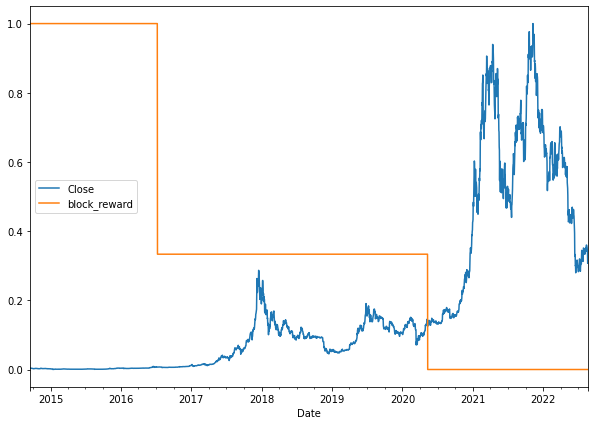

In [86]:
#import minmax_scale from sklearn
from sklearn.preprocessing import minmax_scale

# Plot the block reward/price over time
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Close", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

* After scaling, we can see the price goes up as the block reward goes down
>**Note**: "Close" denotes the closing price of Bitcoin that day

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.
* However, since we've just added another variable to our dataset, these functions won't work.

Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.



In [87]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [88]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Close+{i+1}"] = bitcoin_prices_windowed["Close"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Close,block_reward,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method 
* this is equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [89]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Close", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Close"].astype(np.float32)
X.head()

,block_reward,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [90]:
# View labels
y.head()

Date
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
2014-09-27    399.519989
2014-09-28    377.181000
Name: Close, dtype: float32

Split windowed data into train and test sets using an 80/20 

In [91]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2311, 2311, 578, 578)

## Model 6: Dense (multivariate time series)

* Use `model_1` architecture to train and make predictions on our multivariate time series data.

>By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [92]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [93]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, 
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
19/19 [==============================] - 1s 28ms/step - loss: 2080.0806 - val_loss: 5519.1729
Epoch 2/100
19/19 [==============================] - 0s 23ms/step - loss: 492.8253 - val_loss: 2543.9883
Epoch 3/100
19/19 [==============================] - 0s 23ms/step - loss: 332.9437 - val_loss: 2259.9387
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 303.9388 - val_loss: 2271.7207
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 298.4916 - val_loss: 2334.8228
Epoch 6/100
19/19 [==============================] - 0s 24ms/step - loss: 290.1823 - val_loss: 2137.6074
Epoch 7/100
19/19 [==============================] - 1s 32ms/step - loss: 284.8890 - val_loss: 2076.2451
Epoch 8/100
19/19 [==============================] - 1s 30ms/step - loss: 273.6371 - val_loss: 2067.4048
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 273.5671 - val_loss: 2103.0120
Epoch 10/100
19/19 [==============================] - 0s 

>You might've noticed that the model inferred the input shape of our data automatically (the data now has an extra feature). Often this will be the case, however, if you're running into shape issues, you can always explicitly define the input shape using `input_shape` parameter of the first layer in a model.



In [94]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

19/19 [==============================] - 0s 2ms/step - loss: 1193.2742


1193.274169921875

In [95]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([35545.77 , 31416.59 , 32561.059, 32201.44 , 31924.7  , 32292.785,
       32604.666, 30642.752, 33018.61 , 34316.418], dtype=float32)>

In [96]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 1193.2742,
 'mse': 2772282.5,
 'rmse': 1665.0172,
 'mape': 2.8724523,
 'mase': 1.013278}

In [97]:
model_1_results

{'mae': 1201.919,
 'mse': 2821956.8,
 'rmse': 1679.868,
 'mape': 2.9031937,
 'mase': 1.0206188}

In [98]:
naive_results

{'mae': 1182.6268,
 'mse': 2757842.0,
 'rmse': 1660.6752,
 'mape': 2.8414168,
 'mase': 0.99903446}

It looks like the adding in the block reward may have helped our model slightly.

But there a few more things we could try.

> 📖 **Resource:** For different ideas on how to improve a neural network model (from a model perspective), refer to the [*Improving a model*](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.


> 🛠 **Exercise(s):** 
> 1. Try adding an extra `tf.keras.layers.Dense()` layer with 128 hidden units to `model_6`, how does this effect model performance?
> 2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward`)  works better? See [*Model 4: Hybrid embedding*](https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#model-4-combining-pretrained-token-embeddings-character-embeddings-hybrid-embedding-layer) section of notebook 09 for an idea on how to create a multi-input model.

Add extra `tf.keras.layers.Dense()` layer with 128 hidden units

In [99]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6x = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), 
  layers.Dense(HORIZON)
], name="model_6x_dense_multivariate")

# Compile
model_6x.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6x.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, 
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6x.name)])

Epoch 1/100
19/19 [==============================] - 1s 36ms/step - loss: 1192.4287 - val_loss: 4499.6826
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 352.3008 - val_loss: 1888.1379
Epoch 3/100
19/19 [==============================] - 1s 29ms/step - loss: 229.2839 - val_loss: 1694.5404
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 203.2061 - val_loss: 1645.9768
Epoch 5/100
19/19 [==============================] - 1s 28ms/step - loss: 206.4227 - val_loss: 1433.7491
Epoch 6/100
19/19 [==============================] - 1s 28ms/step - loss: 183.3465 - val_loss: 1380.0273
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 174.0608 - val_loss: 1428.7587
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 173.5543 - val_loss: 1830.3015
Epoch 9/100
19/19 [==============================] - 1s 28ms/step - loss: 188.2009 - val_loss: 1304.2480
Epoch 10/100
19/19 [==============================] - 0s

In [100]:
# Make sure best model is loaded and evaluate
model_6x = tf.keras.models.load_model("model_experiments/model_6x_dense_multivariate")
model_6x.evaluate(X_test, y_test)

19/19 [==============================] - 0s 2ms/step - loss: 1184.3368


1184.3367919921875

In [101]:
# Make predictions on multivariate data
model_6x_preds = tf.squeeze(model_6x.predict(X_test))
model_6x_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([35577.74 , 31228.195, 32800.477, 32216.531, 32351.66 , 32335.078,
       32543.271, 30480.3  , 33259.656, 34380.223], dtype=float32)>

In [102]:
# Evaluate preds
model_6x_results = evaluate_preds(y_true=y_test,
                                  y_pred=model_6x_preds)
model_6x_results

{'mae': 1184.3368,
 'mse': 2761339.2,
 'rmse': 1661.7278,
 'mape': 2.8531284,
 'mase': 1.0056888}

In [103]:
model_6_results

{'mae': 1193.2742,
 'mse': 2772282.5,
 'rmse': 1665.0172,
 'mape': 2.8724523,
 'mase': 1.013278}

In [104]:
model_1_results

{'mae': 1201.919,
 'mse': 2821956.8,
 'rmse': 1679.868,
 'mape': 2.9031937,
 'mase': 1.0206188}

In [105]:
naive_results

{'mae': 1182.6268,
 'mse': 2757842.0,
 'rmse': 1660.6752,
 'mape': 2.8414168,
 'mase': 0.99903446}

* Adding an extra layer helped the model slightly 

## Model 7: N-BEATS algorithm

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

* The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).
* Use the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*




### NBeatsBlock custom layer 

![code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)
*Using TensorFlow layer subclassing to replicate the N-BEATS basic block. See section 3.1 of N-BEATS paper for details.*

Let's see our block replica in action by together by creating a toy version of `NBeatsBlock`.

> 📖  **Resource:** Much of the creation of the time series materials (the ones you're going through now), including replicating the N-BEATS algorithm were streamed live on Twitch. If you'd like to see replays of how the algorithm was replicated, check out the [*Time series research and TensorFlow course material creation playlist*](https://youtube.com/playlist?list=PL8IpyNZ21vUSCM7nRAuS-hW_E-sgwdmaI) on the Daniel Bourke arXiv YouTube channel.

In [106]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Setting up the `NBeatsBlock` custom layer we see: 
* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
  * The hidden layers are created as a stack of fully connected with `n_nuerons` hidden units layers with ReLU activation
  * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is what is run when the layer is called:
  * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned



In [109]:
print(f"Window Size:{WINDOW_SIZE}")
print(f"Horizon: {HORIZON}")

Window Size:7
Horizon: 1


In [116]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [117]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [118]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.07960171  0.32512033 -0.8428683  -0.6938985  -0.31720552 -0.5698734
 -0.6396662 ]
Forecast: 1.0071648359298706


### Preparing data for the N-BEATS algorithm using `tf.data`

We've got the basic building block for the N-BEATS architecture ready to go.

But before we use it to replicate the entire N-BEATS generic architecture, let's create some data.

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).


In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [ ]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Cost+{i+1}"] = bitcoin_prices_nbeats["Cost"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Cost", axis=1)
y = bitcoin_prices_nbeats.dropna()["Cost"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)


Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

We'll do this by:
1. Turning the arrays in tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
  * Note: `from_tensor_slices()` works best when your data fits in memory, for extremely large datasets, you'll want to look into using the [`TFRecord` format](https://www.tensorflow.org/tutorials/load_data/tfrecord)
2. Combine the labels and features tensors into a Dataset using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
  * Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible 

> 📖 **Resource:** For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the [*Better performance with the tf.data API*](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

